In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import cf_helper_2 as cf_helper
import matplotlib.pyplot as plt
import importlib
%matplotlib notebook
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('small')
importlib.reload(cf_helper)

<module 'cf_helper_2' from '/Users/matias/Desktop/Projects/deep learning/python tests/sistemas-de-recomendacion/cf_helper_2.py'>

# Esta notebook contiene pruebas con Content Based y Colaborative Filtering en movielens

In [2]:
! wget http://files.grouplens.org/datasets/movielens/ml-100k.zip

zsh:1: command not found: wget


In [ ]:
! unzip ml-100k.zip

In [3]:
#df = pd.read_csv('movielens/ml-latest-small/ratings.csv')[['userId','movieId','rating']]
header = ['userId', 'movieId', 'rating', 'timestamp']
df = pd.read_csv('./ml-100k/u.data', sep='\t', names=header)

In [4]:
df

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [6]:
def get_user_item_matrix(dataframe, userIndexTag, itemIndexTag,ratingTag, test_size_ratio, base_1 = False):
    first = 0
    if base_1:
        first = 1
    n_users = dataframe[userIndexTag].unique().shape[0]
    n_items = dataframe[itemIndexTag].unique().shape[0]
    train_data, test_data = train_test_split(dataframe, test_size=test_size_ratio)

    R = np.zeros((n_users, n_items))
    T = np.zeros((n_users, n_items))
    print(R.shape)

    for index, line in train_data.iterrows():
        R[line[userIndexTag] - first, line[itemIndexTag] - first] = line[ratingTag]


    for index, line in test_data.iterrows():
        T[line[userIndexTag] - first, line[itemIndexTag] - first] = line[ratingTag]
    print(T.shape)
    return R,T
R_train, R_test = get_user_item_matrix(df, 'userId','movieId','rating',0.25, base_1 = True)

(943, 1682)
(943, 1682)


In [7]:
R_train[0]

array([0., 3., 4., ..., 0., 0., 0.])

In [8]:
R_rated_indexes_train = R_train.nonzero()
R_rated_indexes_test = R_test.nonzero()

In [9]:
I_train = R_train.copy()
T_test = R_test.copy()
I_train[I_train==0] = 0
I_train[I_train!=0] = 1
T_test[T_test==0] = 0
T_test[T_test!=0] = 1

In [10]:
def get_estimated_R(SM, R_tr, R_ts, R_rated_indexes_tr, R_rated_indexes_ts, k = -1, means = 0,divide_by_weights_sum = True, count_diag = False, relevant_rate = 1, perc_points = 100):
    if k==-1:
        R_est = cf_helper.predictions(R_tr, SM, divide_by_weights_sum= divide_by_weights_sum, count_diag = count_diag, means = means)
    else:
        R_est = cf_helper.predictions_K_neighbours(R_tr, SM, k=k, means = means, divide_by_weights_sum= divide_by_weights_sum, count_diag = count_diag)
    rmse_tr= cf_helper.rmse(R_tr,R_est)
    rmse_ts = cf_helper.rmse(R_ts, R_est)
    perc = cf_helper.get_percentiles(R_ts, R_est, like = relevant_rate, points = perc_points, number_of_random_items = 500)
    print(rmse_tr,rmse_ts)
    return R_est, perc, rmse_ts

In [11]:
perc_points = 100
relevant_rate = 5

In [12]:
SM_pearson2, user_means2 = cf_helper.getPearsonSimilarityMatrix_non_zeros(R_train)

In [13]:
SM_jaccard, _ = cf_helper.calcultaSimilarityMatrix(R_train, dist_type ='jaccard_with_negatives')
SM_pearson, user_means = cf_helper.calcultaSimilarityMatrix(R_train, dist_type ='pearson')
SM_cosine, _ = cf_helper.calcultaSimilarityMatrix(R_train, dist_type ='cosine')

In [14]:
R_est_pearson2, perc_pearson2, rmse_pearson2 = get_estimated_R(SM_pearson2, R_train, R_test, R_rated_indexes_train, 
                                                               R_rated_indexes_test, 
                                                               means = user_means2, perc_points = perc_points, relevant_rate = relevant_rate)

1.905656049874064 1.950034167206693


In [15]:
R_est_pearson, perc_pearson, rmse_pearson = get_estimated_R(SM_pearson, R_train, R_test, R_rated_indexes_train, 
                                                            R_rated_indexes_test, means = user_means, 
                                                            perc_points = perc_points, relevant_rate = relevant_rate)

2.8947386812561113 2.958207499865513


In [16]:
R_est_cosine, perc_cosine, rmse_cosine = get_estimated_R(SM_cosine, R_train, R_test, R_rated_indexes_train, R_rated_indexes_test, perc_points = perc_points, relevant_rate = relevant_rate, means = 0)

2.9996547217296636 3.048018664752882


In [17]:
R_est_jaccard, perc_jaccard, rmse_jaccard = get_estimated_R(SM_jaccard,R_train, R_test, R_rated_indexes_train, R_rated_indexes_test, perc_points = perc_points, relevant_rate = relevant_rate)

2.9574430286519586 3.0098922342963452


In [18]:
mu_train = R_train[R_rated_indexes_train].mean()
percentiles_train_media = cf_helper.get_percentiles(R_test, mu_train*np.ones(R_train.shape), like = 5)

In [19]:
def get_biased_data(R_tr, bias):
    R_tr_b = R_tr.copy()
    R_tr_b[R_tr==0] = bias
    return R_tr_b

In [20]:
R_train_biased = get_biased_data(R_train, mu_train)
SM_biased, user_means_biased = cf_helper.calcultaSimilarityMatrix(R_train_biased, dist_type ='pearson')
R_est_biased, perc_biased, rmse_biased = get_estimated_R(SM_biased, R_train_biased, R_test, R_rated_indexes_train, R_rated_indexes_test, means=user_means_biased, relevant_rate = relevant_rate)

0.22920655937231926 1.0715665662489595


/Users/matias/Desktop/Projects/deep learning/python tests/sistemas-de-recomendacion/cf_helper_2.py:537: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


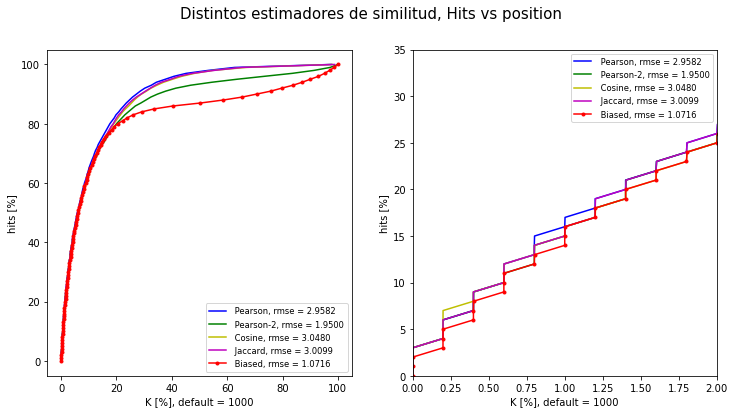

In [21]:
%matplotlib inline
perc_basis_vect = [perc_pearson, perc_pearson2,perc_cosine, perc_jaccard, perc_biased]
rmse_basis_vect = [rmse_pearson, rmse_pearson2,rmse_cosine, rmse_jaccard, rmse_biased]
names_basis_vect = ['Pearson','Pearson-2','Cosine','Jaccard', 'Biased']
cf_helper.plot_percentiles(names_basis_vect, rmse_basis_vect, perc_basis_vect,
                 parameter_name ='', title= 'Distintos estimadores de similitud, Hits vs position',
                 featured_idx = 4, featured_text = 'Biased')

In [22]:
f, ([ax1, ax2]) = plt.subplots(1,2, sharex=False, sharey=False, figsize=(12, 6)) #, figsize=(10, 10)
plt_jaccard, = ax1.plot(*perc_jaccard, color = 'k', label = 'jaccard, rmse = %.4f'%rmse_jaccard)
plt_cosine, = ax1.plot(*perc_cosine, color = 'y', label = 'cosine, rmse = %.4f'%rmse_cosine)
plt_pearson, = ax1.plot(*perc_pearson, color = 'b', label = 'pearson, rmse = %.4f'%rmse_pearson)
plt_pearson2, = ax1.plot(*perc_pearson2, color = 'R', label = 'pearson2, rmse = %.4f'%rmse_pearson2)

ax1.plot(*percentiles_train_media, linestyle = ":", color = 'k')

ax1.legend(handles=[plt_pearson, plt_pearson2, plt_cosine, plt_jaccard], loc = 'best', prop = fontP)
ax1.set_xlabel('K [%], default = 1000')
ax1.set_ylabel('hits [%]')

ax2.plot(*perc_jaccard,  color = 'k')
ax2.plot(*perc_cosine,  color = 'y')
ax2.plot(*perc_pearson, color = 'b')
ax2.plot(*perc_pearson2, color = 'r')

ax2.legend(handles=[plt_pearson, plt_cosine, plt_jaccard], loc = 'best', prop = fontP)
ax2.set_xlabel('K [%], default = 1000')
ax2.set_ylabel('hits [%]')
ax2.set_ylim([0,35])
ax2.set_xlim([0,2])

print('\n Ejemplo: si k=2 y hits=30 \n El 30% de los items relevantes se encuentran dentro de los primeros 20 items (1000 * k/100)')
f.suptitle('Distintos estimadores de similitud, Hits vs position', fontsize = 15)
f.show()


 Ejemplo: si k=2 y hits=30 
 El 30% de los items relevantes se encuentran dentro de los primeros 20 items (1000 * k/100)
Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f8d9fc33950> (for post_execute):


/Users/matias/opt/anaconda3/envs/deep_learning/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


ValueError: Invalid RGBA argument: 'R'

ValueError: Invalid RGBA argument: 'R'

<Figure size 864x432 with 2 Axes>

# Matrix Factorization

In [23]:
from cf_helper_2 import Matrix_Factorization_baselines_SGD

In [24]:
mu = R_train[R_train.nonzero() ].mean()

In [ ]:
# gamma: Learning rate
P, Q, bu, bi, train_rmse_vector, test_rmse_vector, train_accuracy_vector, train_accuracy_vector, gamma, lmbda \
= Matrix_Factorization_baselines_SGD(R_train , R_test, R_rated_indexes_train, R_rated_indexes_test, mu, k=18 
                                     ,sigma = 0.002,
                           gamma= 0.01, lmbda = 0.15, alpha = 0., 
                           n_epochs = 400, error_calc_frec = 1,
                           accuracy_thres = 0, like = 1, dislike = -1)

epoch = -1 accuracy (train, test): (6.1640, 5.9480), rmse (train, test): (1.126675, 1.122626)
epoch = 0 accuracy (train, test): (6.1640, 5.9480), rmse (train, test): (0.976177, 0.988495)
epoch = 1 accuracy (train, test): (6.1640, 5.9480), rmse (train, test): (0.951647, 0.969107)
epoch = 2 accuracy (train, test): (6.1640, 5.9480), rmse (train, test): (0.940873, 0.961224)
epoch = 3 accuracy (train, test): (6.1640, 5.9480), rmse (train, test): (0.934751, 0.957022)
epoch = 4 accuracy (train, test): (6.1640, 5.9480), rmse (train, test): (0.930836, 0.954502)
epoch = 5 accuracy (train, test): (6.1640, 5.9480), rmse (train, test): (0.928143, 0.952880)
epoch = 6 accuracy (train, test): (6.1640, 5.9480), rmse (train, test): (0.926195, 0.951784)
epoch = 7 accuracy (train, test): (6.1640, 5.9480), rmse (train, test): (0.924730, 0.951015)
epoch = 8 accuracy (train, test): (6.1640, 5.9480), rmse (train, test): (0.923593, 0.950459)
epoch = 9 accuracy (train, test): (6.1640, 5.9480), rmse (train, test

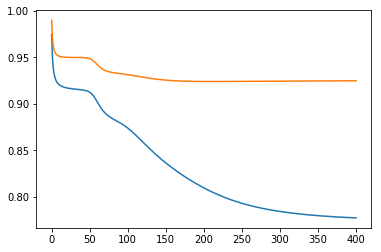

In [159]:
plt.plot(train_rmse_vector)
plt.plot(test_rmse_vector)
plt.show()

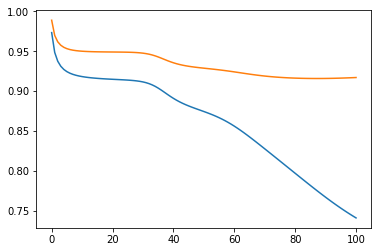

In [153]:
# Lambda = 0.1
plt.plot(train_rmse_vector)
plt.plot(test_rmse_vector)
plt.show()